<a href="https://colab.research.google.com/github/vivek6311/Artificial-Intelligence-with-Python/blob/master/Mizoram_PES_IPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
import textwrap

In [ ]:
df= pd.read_excel('/content/PES OPD.xlsx')

In [ ]:
df.head()

,Sl.No,Type of Facility,Facility Name,Type of Unit,Age of the Patient,What was the total monthly expenditure on health of all members in the family,Distance from residence to Health Care Facility (In KM),Gender,Frequency of visit to the Health Care Facility,Why did you choose to visit this Health Care Facility?,...,Did the doctor/health worker/other staff speak to you in a language you can understand?,Did the doctor/nurse /other staff answer your questions politely and respectfully in a way which was helpful for you?,Was there any occasion where you felt that the health care staff behaved inappropriately?,Was there seating/toilet available at the waiting area?,Is Drinking water available?,Could you access the toilet near the waiting area when needed?,"At the health facility were there clear signs and labels to show directions (for areas such as waiting room, examination room, labs, etc)",Which place you are referred to for what?,Are you satisfied with the services provided in the hospital?,Are you enrolled in any Government insurance?
0,1,PHC,Haulawng PHC,General Medicine,40,1000,2,F,2,Doctor and service are good,...,Yes,Yes,Never,Yes,Yes,Yes,Yes,Lunglei DH for Ultrasound,Yes,Yes
1,2,PHC,Haulawng PHC,General Medicine,52,3000,2,F,2,Doctor and service are good,...,Yes,Yes,Never,Yes,Yes,Yes,Yes,Lunglei DH for X-Ray,Yes,Yes
2,3,PHC,Haulawng PHC,General Medicine,54,2500,16,M,2,Doctor and service are good,...,Yes,Yes,Never,Yes,Yes,Yes,Yes,Not Referred,Yes,Yes
3,4,PHC,Haulawng PHC,General Medicine,2,150,5,M,2,Doctor and service are good,...,Yes,Yes,Never,Yes,Yes,Yes,Yes,ZMC,Yes,Yes
4,5,PHC,Haulawng PHC,General Medicine,1,3000,2,M,2,Doctor and service are good,...,Yes,Yes,Never,Yes,Yes,Yes,Yes,Champhai DH,Yes,Yes


In [ ]:
# 2. INITIAL DATA PREP
# Drop unnamed columns & fill missing header if necessary
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  # remove unnamed columns

In [ ]:
df.head()

,Sl.No,Type of Facility,Facility Name,Type of Unit,Age of the Patient,What was the total monthly expenditure on health of all members in the family,Distance from residence to Health Care Facility (In KM),Gender,Frequency of visit to the Health Care Facility,Why did you choose to visit this Health Care Facility?,...,Did the doctor/health worker/other staff speak to you in a language you can understand?,Did the doctor/nurse /other staff answer your questions politely and respectfully in a way which was helpful for you?,Was there any occasion where you felt that the health care staff behaved inappropriately?,Was there seating/toilet available at the waiting area?,Is Drinking water available?,Could you access the toilet near the waiting area when needed?,"At the health facility were there clear signs and labels to show directions (for areas such as waiting room, examination room, labs, etc)",Which place you are referred to for what?,Are you satisfied with the services provided in the hospital?,Are you enrolled in any Government insurance?
0,1,PHC,Haulawng PHC,General Medicine,40,1000,2,F,2,Doctor and service are good,...,Yes,Yes,Never,Yes,Yes,Yes,Yes,Lunglei DH for Ultrasound,Yes,Yes
1,2,PHC,Haulawng PHC,General Medicine,52,3000,2,F,2,Doctor and service are good,...,Yes,Yes,Never,Yes,Yes,Yes,Yes,Lunglei DH for X-Ray,Yes,Yes
2,3,PHC,Haulawng PHC,General Medicine,54,2500,16,M,2,Doctor and service are good,...,Yes,Yes,Never,Yes,Yes,Yes,Yes,Not Referred,Yes,Yes
3,4,PHC,Haulawng PHC,General Medicine,2,150,5,M,2,Doctor and service are good,...,Yes,Yes,Never,Yes,Yes,Yes,Yes,ZMC,Yes,Yes
4,5,PHC,Haulawng PHC,General Medicine,1,3000,2,M,2,Doctor and service are good,...,Yes,Yes,Never,Yes,Yes,Yes,Yes,Champhai DH,Yes,Yes


In [ ]:
# Set which columns to treat specially
first_5 = df.columns[:7]       # Meta columns
data_cols = df.columns[7:]     # All columns from 6th onward, as per your instructions

In [ ]:
# 3. DATA CLEANING & ENCODING
df_data = df[data_cols].copy()
df_data = df_data.astype(str)   # Convert all to string for one-hot encoding


In [ ]:
# One-hot encode ALL non-numeric columns in the selected data
df_oh = pd.get_dummies(df_data)

In [ ]:
# Optional: Remove columns with only one unique value (not informative)
df_oh = df_oh.loc[:, df_oh.nunique() > 1]

In [ ]:
# Impute any NaNs (should be none after get_dummies, but just in case)
df_oh = df_oh.fillna(0)

In [ ]:
# Save the one-hot encoded full dataset
df_oh.to_excel("PES_OPD_encoded_data.xlsx", index=False)

In [ ]:
# 3. DATA VISUALISATION (as before)
corr_matrix = df_oh.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': 0.5},
            xticklabels=False, yticklabels=False)
plt.title("Correlation Heatmap of Encoded Features")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.close()

# 4. ITERATIVE PCA + CLUSTERING + EXPORTS
iterations = 3
top_features = 15
n_components_pca = 5
n_clusters = 3

current_df = df_oh.copy()
important_features_all = []
pc_loadings_all = []

os.makedirs("iteration_outputs", exist_ok=True)

for i in range(iterations):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(current_df)
    pca = PCA(n_components=n_components_pca)
    X_pca = pca.fit_transform(X_scaled)

    # Save explained variance plot
    plt.figure()
    plt.bar(range(1, n_components_pca + 1), pca.explained_variance_ratio_)
    plt.xlabel('PCA Component')
    plt.ylabel('Explained Variance')
    plt.title(f'Iteration {i+1} - Explained Variance by Component')
    plt.tight_layout()
    plt.savefig(f"iteration_outputs/iter_{i+1}_explained_variance.png")
    plt.close()

    # Clustering (KMeans)
    km = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = km.fit_predict(X_pca)
    current_df["Cluster"] = clusters  # temporarily add for saving

    plt.figure()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.title(f'Iteration {i+1} - KMeans Clusters in PCA space')
    plt.tight_layout()
    plt.savefig(f"iteration_outputs/iter_{i+1}_kmeans_clusters.png")
    plt.close()

    # Save cluster labels file
    current_df[["Cluster"]].to_csv(f"iteration_outputs/iter_{i+1}_clusters.csv")

    # Find the top features contributing to all PCs
    loadings = pd.DataFrame(pca.components_.T,
                            columns=[f"PC{j+1}" for j in range(n_components_pca)],
                            index=current_df.drop('Cluster', axis=1).columns)  # drop temp Cluster
    important_features = set()
    pca_feature_scores = []

    for pc in loadings.columns:
        feats = loadings[pc].abs().sort_values(ascending=False).head(top_features)
        important_features.update(feats.index)
        for name, score in feats.items():
            pca_feature_scores.append({"Iteration": i+1, "PC": pc, "Feature": name, "Abs_Loading": score})

    # Save PCA loadings per-iteration
    loadings.to_csv(f"iteration_outputs/iter_{i+1}_pca_loadings.csv")

    # Save top PCA features with scores per-iteration
    pd.DataFrame(pca_feature_scores).to_csv(f"iteration_outputs/iter_{i+1}_top_pca_features.csv", index=False)

    important_features_all.append(list(important_features))
    pc_loadings_all.extend(pca_feature_scores)

    current_df = current_df[list(important_features)]  # next round, just keep important
    # Remove Cluster col if present
    if 'Cluster' in current_df.columns:
        current_df = current_df.drop('Cluster', axis=1)

# FINAL: Save final important features and PCA scores
final_features = current_df.columns.tolist()
pd.Series(final_features, name="FinalImportantFeatures").to_csv("final_important_features.csv", index=False)
pd.DataFrame(pc_loadings_all).to_csv("all_iterations_important_pca_features.csv", index=False)

print("✅ All files saved:")
print("- one_hot_encoded_data.xlsx")
print("- correlation_heatmap.png")
print("- iteration_outputs/ (per-iteration PCA loadings, clustering, feature scores, variance, clusters plots)")
print("- final_important_features.csv")
print("- all_iterations_important_pca_features.csv")

✅ All files saved:
- one_hot_encoded_data.xlsx
- correlation_heatmap.png
- iteration_outputs/ (per-iteration PCA loadings, clustering, feature scores, variance, clusters plots)
- final_important_features.csv
- all_iterations_important_pca_features.csv


Top 10 features: ['Which place you are referred to for what?_Not Referred', 'Did the doctor/nurse discuss your condition/symptoms and treatment with you in a way you could understand?_Always', 'Did the doctor/nurse tell you about any side effects of the medicines? _No', 'Did the doctor/nurse tell you about any side effects of the medicines? _Yes', 'What services did you avail in the Health Care Facility?_Medical Checkup', 'How do you see the waiting time before being seen in consultation by the doctor?_Long', 'How do you see the waiting time before being seen in consultation by the doctor?_Short', 'What services did you avail in the Health Care Facility?_Checkup, diagnostic & medicine', 'Did the doctor/health worker/other staff tell you about any danger signs to look out for? _No', 'Which place you are referred to for what?_Not referred']
Top 5 features: ['Which place you are referred to for what?_Not Referred', 'Did the doctor/nurse discuss your condition/symptoms and treatment with y

/tmp/ipython-input-13-3239430084.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


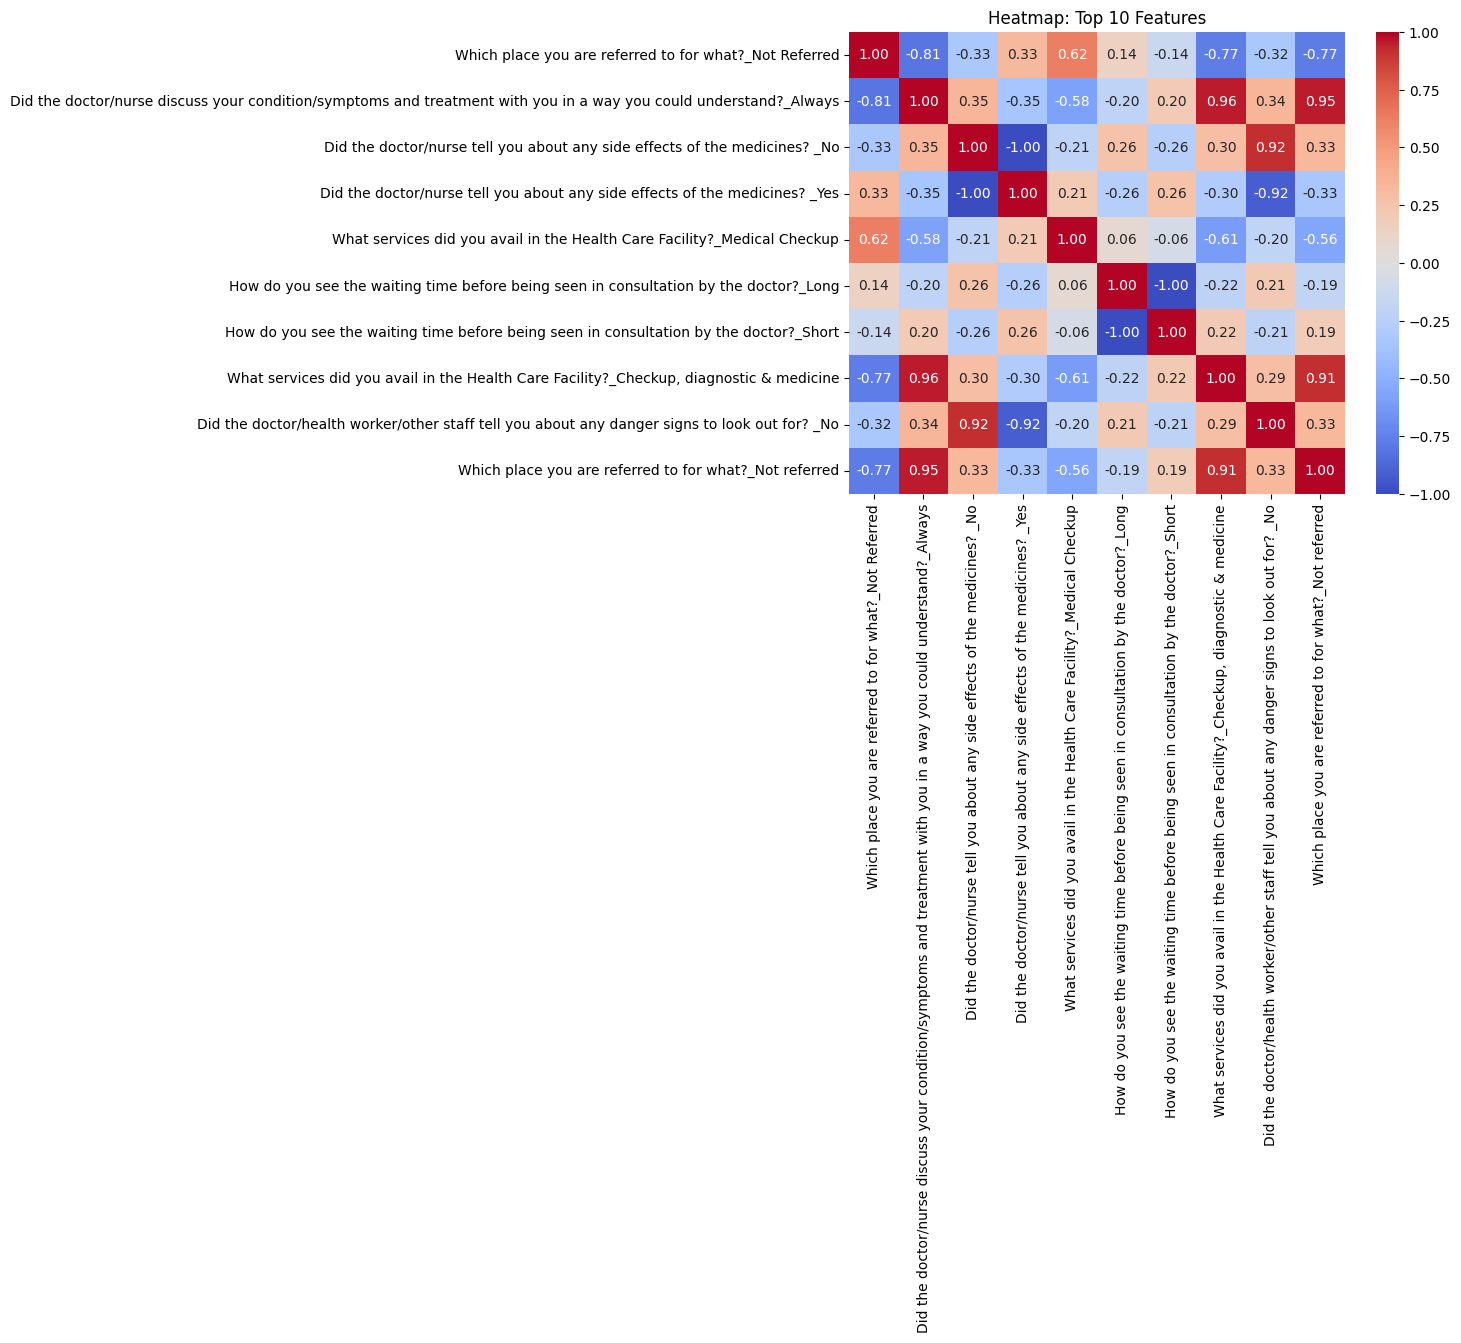

/tmp/ipython-input-13-3239430084.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


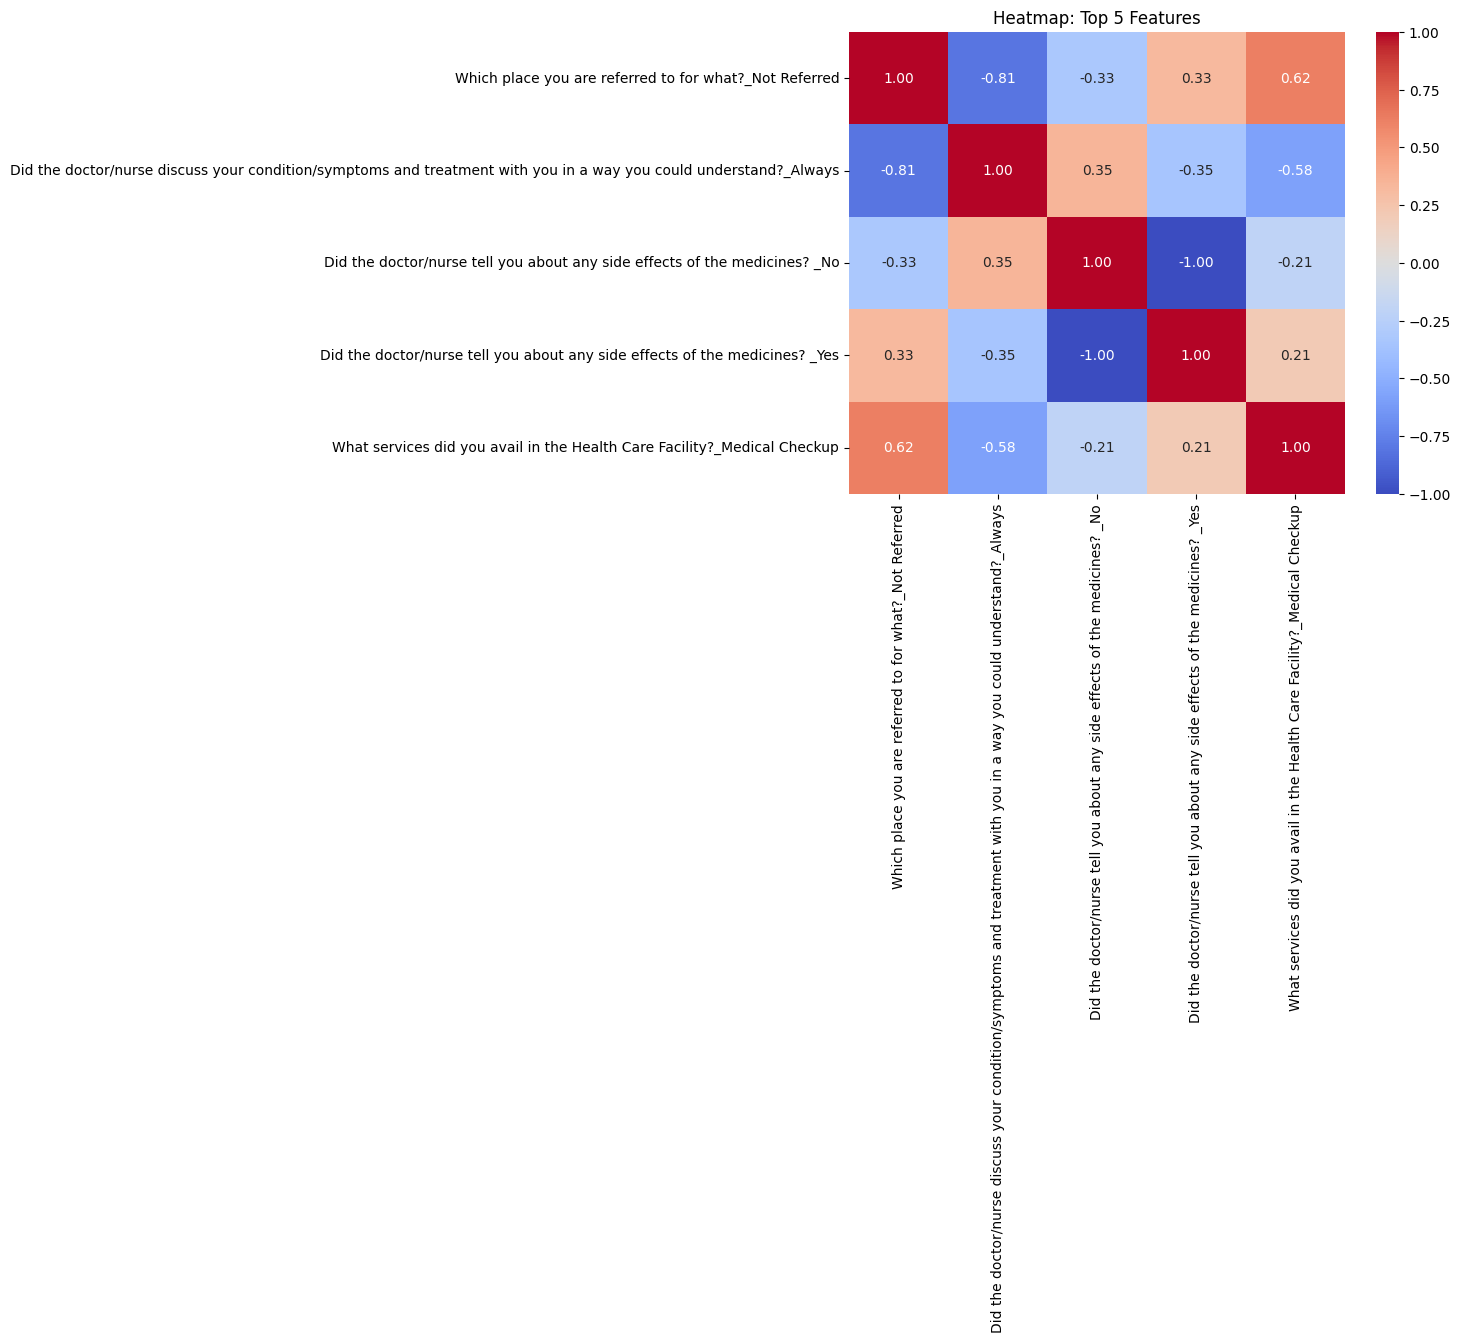

/tmp/ipython-input-13-3239430084.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


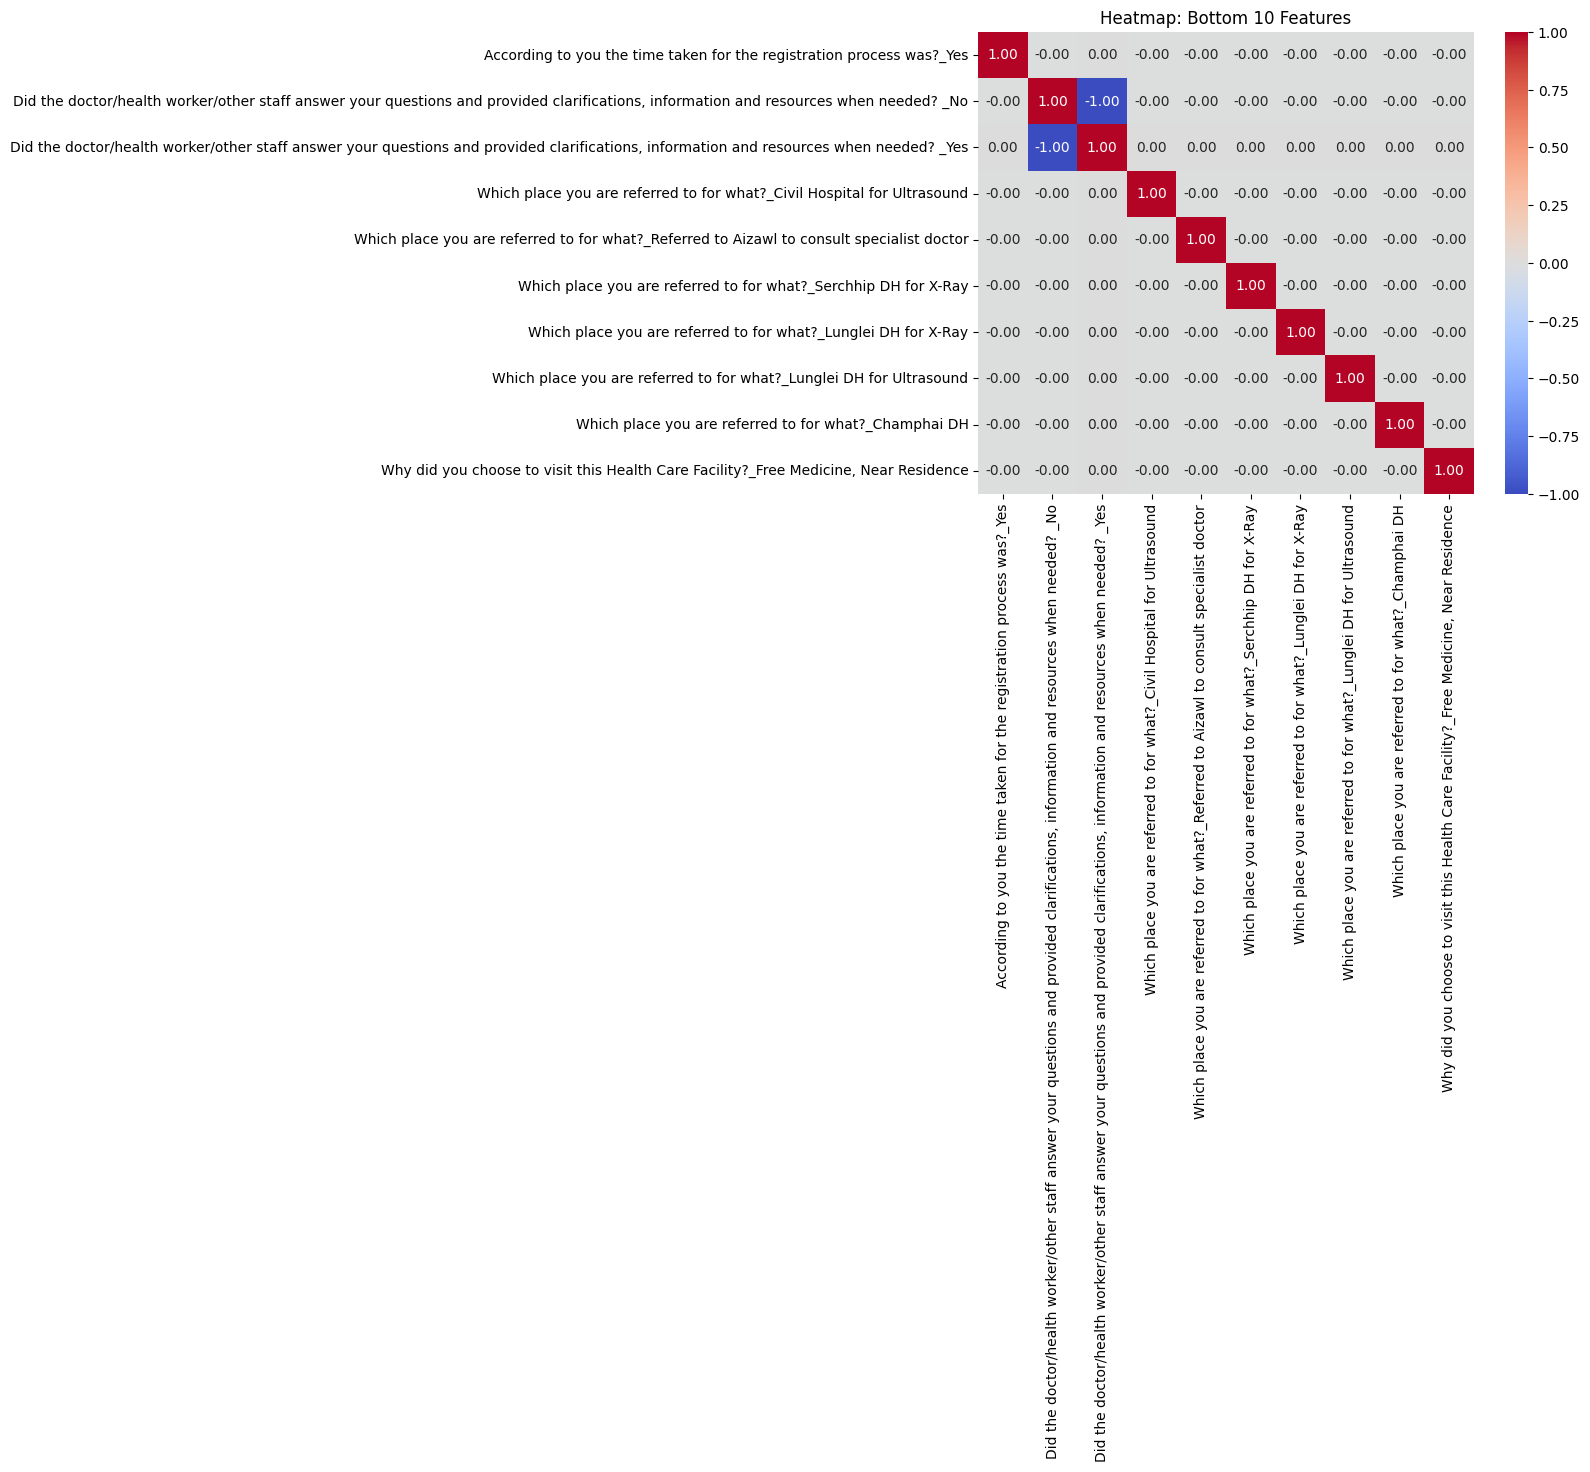

/tmp/ipython-input-13-3239430084.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


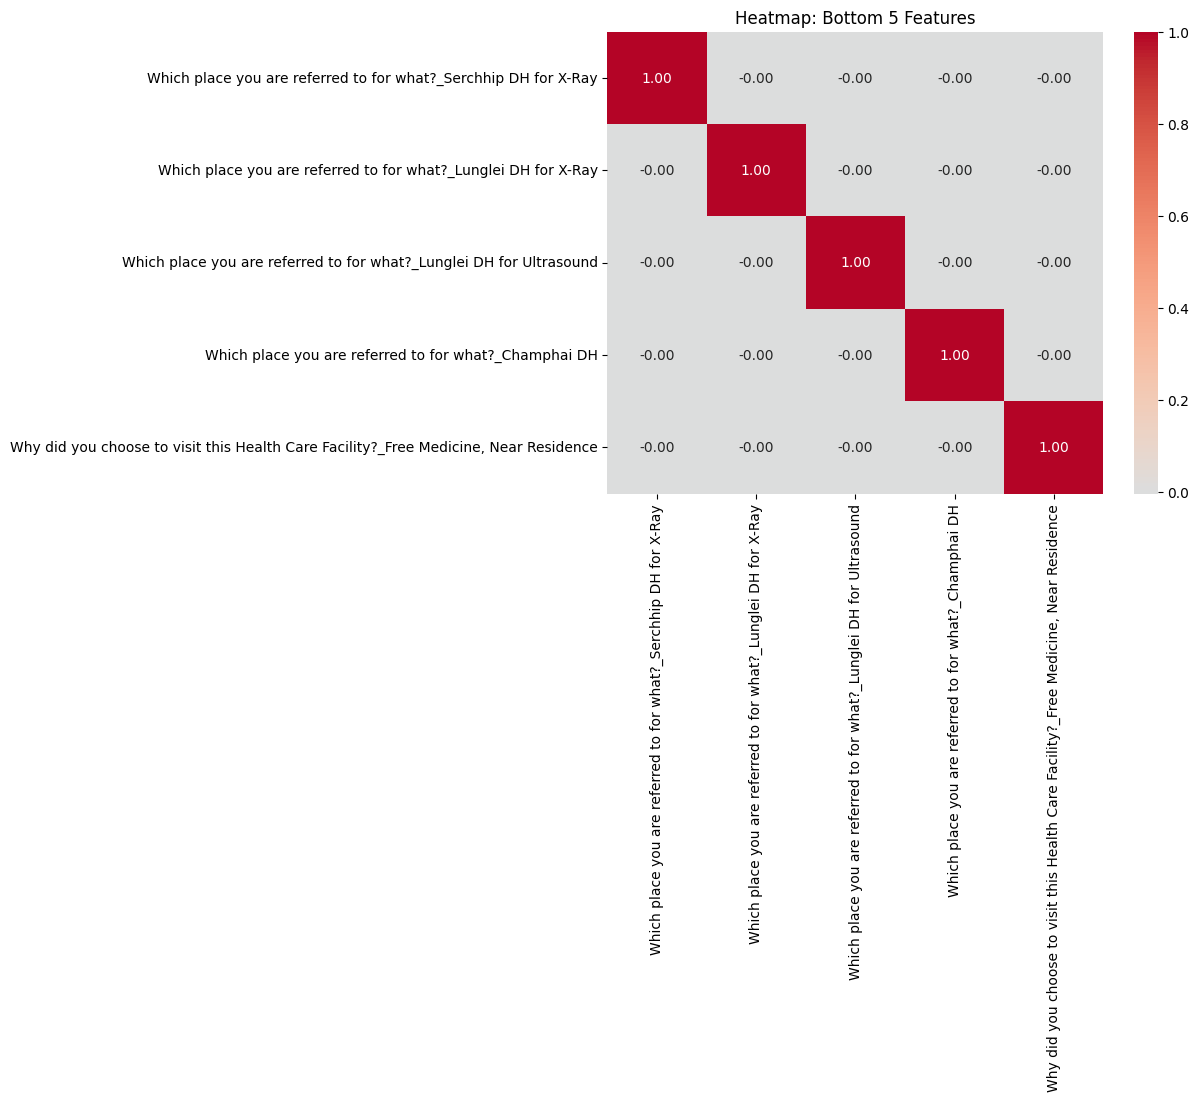

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate correlation matrix
corr_matrix = df_oh.corr()

# 2. Compute mean absolute correlation for each feature (excluding self-correlation)
mean_abs_corr = corr_matrix.abs().replace(1, np.nan).mean().sort_values(ascending=False)

# 3. Identify feature lists
top_10 = mean_abs_corr.head(10).index.tolist()
top_5 = mean_abs_corr.head(5).index.tolist()
bottom_10 = mean_abs_corr.tail(10).index.tolist()
bottom_5 = mean_abs_corr.tail(5).index.tolist()

# 4. Print feature lists
print("Top 10 features:", top_10)
print("Top 5 features:", top_5)
print("Bottom 10 features:", bottom_10)
print("Bottom 5 features:", bottom_5)

# 5. Print correlation matrices for top/bottom features
print("\nCorrelation matrix for Top 10 features:")
print(corr_matrix.loc[top_10, top_10])
print("\nCorrelation matrix for Top 5 features:")
print(corr_matrix.loc[top_5, top_5])
print("\nCorrelation matrix for Bottom 10 features:")
print(corr_matrix.loc[bottom_10, bottom_10])
print("\nCorrelation matrix for Bottom 5 features:")
print(corr_matrix.loc[bottom_5, bottom_5])

# 6. Heatmap plotting function
def plot_heatmap(feature_list, matrix, title):
    plt.figure(figsize=(8,6))
    subset = matrix.loc[feature_list, feature_list]
    sns.heatmap(subset, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 7. Draw all requested heatmaps
plot_heatmap(top_10, corr_matrix, "Heatmap: Top 10 Features")
plot_heatmap(top_5, corr_matrix, "Heatmap: Top 5 Features")
plot_heatmap(bottom_10, corr_matrix, "Heatmap: Bottom 10 Features")
plot_heatmap(bottom_5, corr_matrix, "Heatmap: Bottom 5 Features")

In [ ]:
# Calculate correlation matrix and mean absolute correlations
corr_matrix = df_oh.corr()
mean_abs_corr = corr_matrix.abs().replace(1, np.nan).mean().sort_values(ascending=False)

# Identify feature lists
top_10 = mean_abs_corr.head(10).index.tolist()
top_5 = mean_abs_corr.head(5).index.tolist()
bottom_10 = mean_abs_corr.tail(10).index.tolist()
bottom_5 = mean_abs_corr.tail(5).index.tolist()

def wrap_labels(labels, width=16):
    return ['\n'.join(textwrap.wrap(str(label), width)) for label in labels]

# Prepare subplots
fig, axs = plt.subplots(2, 2, figsize=(30,30))
feature_sets = [(top_10, "Top 10 Features"),
                (top_5, "Top 5 Features"),
                (bottom_10, "Bottom 10 Features"),
                (bottom_5, "Bottom 5 Features")]

for ax, (feature_list, title) in zip(axs.flat, feature_sets):
    wrapped_labels = wrap_labels(feature_list)
    subset = corr_matrix.loc[feature_list, feature_list]
    sns.heatmap(subset, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                xticklabels=wrapped_labels, yticklabels=wrapped_labels, ax=ax)
    ax.set_title(title)

plt.tight_layout()
plt.savefig("correlation_heatmaps_all.png", dpi=300)   # Save as PNG
plt.savefig("correlation_heatmaps_all.pdf")            # Or as PDF for high quality
plt.close()

print("✅ All four heatmaps have been saved together in 'correlation_heatmaps_all.png' and 'correlation_heatmaps_all.pdf'.")


✅ All four heatmaps have been saved together in 'correlation_heatmaps_all.png' and 'correlation_heatmaps_all.pdf'.


In [ ]:
# Assume df_oh is your one-hot encoded DataFrame already loaded

iterations = 100
top_features = 15
n_components_pca = 5
save_iters = [1, 10, 50, 90, 95, 100]  # Save and print data for these iterations
save_data = {}  # Dictionary to store results for these iterations

current_df = df_oh.copy()
os.makedirs("iteration_outputs", exist_ok=True)

for i in range(1, iterations + 1):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(current_df)
    pca = PCA(n_components=n_components_pca)
    X_pca = pca.fit_transform(X_scaled)

    # Explained variance and cumulative variance
    explained_var_ratio = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var_ratio)
    n_pc = len(explained_var_ratio)
    explained_df = pd.DataFrame({
        'PC': [f'PC{i+1}' for i in range(n_pc)],
        'Explained Variance Ratio': explained_var_ratio,
        'Cumulative Variance': cumulative_var
    })

    # Print PCA explained variance for the desired iterations
    if i in save_iters:
        print(f"\n=== PCA Explained Variance (Iteration {i}) ===")
        print(explained_df)

    # Find top contributing features by absolute loading per PC
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f"PC{j + 1}" for j in range(n_components_pca)],
        index=current_df.columns
    )
    important_features = set()
    pca_scores = []
    for pc in loadings.columns:
        feats = loadings[pc].abs().sort_values(ascending=False).head(top_features)
        important_features.update(feats.index)
        for name, score in feats.items():
            pca_scores.append({
                "Iteration": i,
                "PC": pc,
                "Feature": name,
                "Abs_Loading": score
            })

    # Save data for specified iterations
    if i in save_iters:
        df_selected = current_df[list(important_features)].copy()
        df_selected['__Iteration__'] = i
        pca_scores_df = pd.DataFrame(pca_scores)
        df_pca_scores = pd.DataFrame(
            X_pca, columns=[f'PC{j+1}_score' for j in range(n_components_pca)]
        )
        df_pca_scores['SampleIndex'] = df_selected.index

        # Store as tuple for export later
        save_data[i] = (
            df_selected,       # selected features subset
            pca_scores_df,     # PCA loadings (feature contributions)
            df_pca_scores,     # PCA scores per sample (PC1..PC5)
            explained_df       # PCA explained variance DataFrame
        )

    # Prepare for next iteration with only important features
    current_df = current_df[list(important_features)]
    # Remove Cluster if added in original code (not done here, but safe to check)
    if 'Cluster' in current_df.columns:
        current_df = current_df.drop('Cluster', axis=1)

# After iterations, save all collected data in one Excel file with separate sheets
with pd.ExcelWriter('selected_iterations_results.xlsx', engine='openpyxl') as writer:
    for it in save_iters:
        feat_df, pca_scores_df, score_df, explained_df = save_data[it]
        feat_df.to_excel(writer, sheet_name=f'Features_Iter{it}', index=False)
        pca_scores_df.to_excel(writer, sheet_name=f'Loadings_Iter{it}', index=False)
        score_df.to_excel(writer, sheet_name=f'Scores_Iter{it}', index=False)
        explained_df.to_excel(writer, sheet_name=f'PCA_Var_Iter{it}', index=False)

print("\n✅ Selected iterations’ PCA results saved in 'selected_iterations_results.xlsx'.")



=== PCA Explained Variance (Iteration 1) ===
    PC  Explained Variance Ratio  Cumulative Variance
0  PC1                  0.116487             0.116487
1  PC2                  0.105344             0.221831
2  PC3                  0.058830             0.280662
3  PC4                  0.052794             0.333455
4  PC5                  0.050964             0.384419

=== PCA Explained Variance (Iteration 10) ===
    PC  Explained Variance Ratio  Cumulative Variance
0  PC1                  0.183514             0.183514
1  PC2                  0.154142             0.337655
2  PC3                  0.101058             0.438713
3  PC4                  0.086167             0.524880
4  PC5                  0.075727             0.600607

=== PCA Explained Variance (Iteration 50) ===
    PC  Explained Variance Ratio  Cumulative Variance
0  PC1                  0.183514             0.183514
1  PC2                  0.154142             0.337655
2  PC3                  0.101058             0.438